In [1]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [2]:
!pip install supervision -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 4.4 MB/s eta 0:00:00


In [3]:
!mkdir -p weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P weights

In [4]:
!pip install jupyter-bbox-widget  -q
!jupyter nbextension enable --py --sys-prefix jupyter-bbox-widget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.8 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbextension", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/notebook/nbextensions.py", line 972, in start
    super().start()
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 270, in start
    self.subapp.start()
  File "/usr/local/lib/python3.10/dist-packages/notebook/nbextensions.py", line 882, in start
    self.toggle_nbextension_python(self.extra_args[0])
  File "/usr/local/lib/python3.10/dist-packages/not

In [5]:
import torch
import cv2
import base64
import numpy as np
import supervision as sv
import warnings
warnings.filterwarnings("ignore")
from google.colab import output
output.enable_custom_widget_manager()
from jupyter_bbox_widget import BBoxWidget
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
sam = sam_model_registry["vit_h"](checkpoint="weights/sam_vit_h_4b8939.pth").to(device=DEVICE)

In [8]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [10]:
image_path = "./content/pet.jpg"
image_bgr = cv2.imread(image_path)
image_rgb =  cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [15]:
sam_result[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

use this [link](https://supervision.roboflow.com/latest/detection/annotators/#supervision.annotators.core.MaskAnnotator.annotate)

In [85]:
mask_annotator =  sv.MaskAnnotator()
masks = sam_result

# extract bounding boxes and create detections
xyxy = []
mask_list = []
for mask in masks:
    x, y, w, h = mask['bbox']
    xyxy.append([x, y, x + w, y + h])
    mask_list.append(mask['segmentation'])

# random colors
num_masks = len(mask_list)
colors = np.random.randint(0, 255, (num_masks, 3))

if len(xyxy) > 0:
    detections = sv.Detections(xyxy=np.array(xyxy))
else:
    detections = sv.Detections(xyxy=np.empty((0, 4)))

# annotate the image with the detected masks
mask_annotator = sv.MaskAnnotator()

annotated_image = image_rgb.copy()
for i, mask in enumerate(mask_list):
    color = colors[i]
    annotated_image[mask > 0] = color

# annotate the image with bounding boxes
annotated_image = mask_annotator.annotate(
    scene=annotated_image,
    detections=detections
)

# blend the annotated image with the original image using a low opacity
final_image = cv2.addWeighted(image_bgr, 0.5, annotated_image, 0.5, 0)


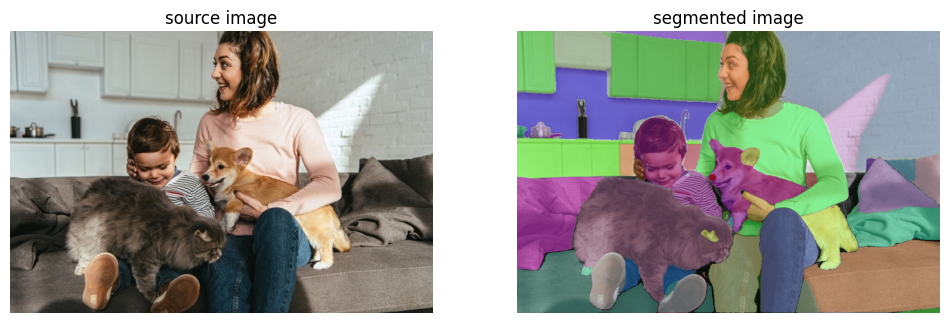

In [80]:
sv.plot_images_grid(
    images=[image_bgr, final_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

82


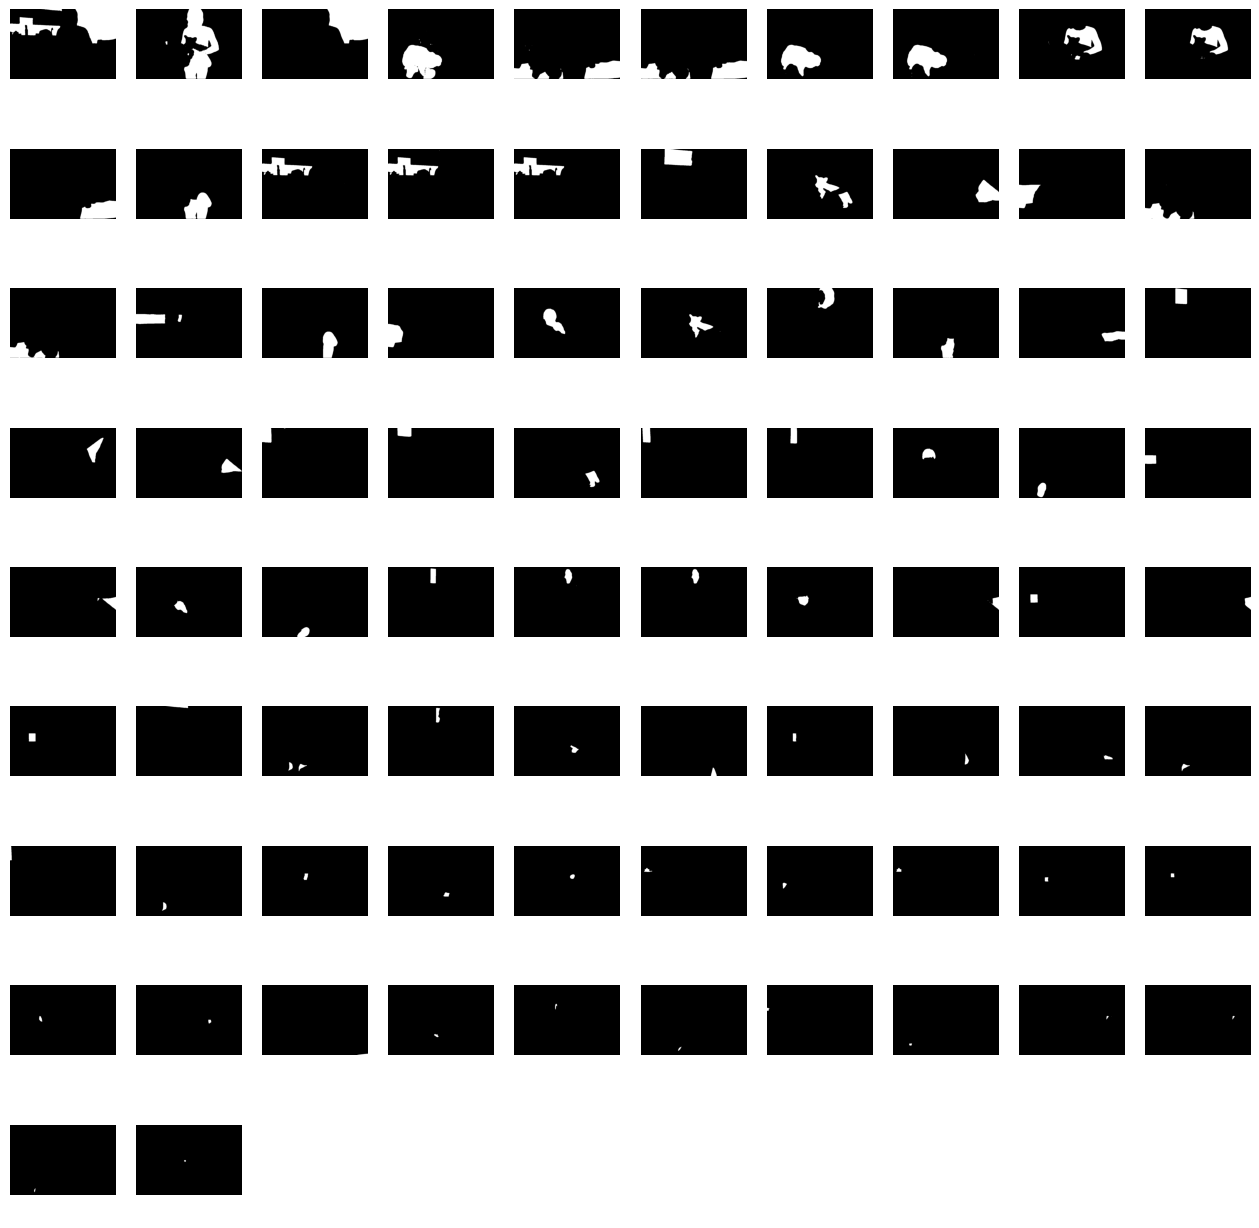

In [19]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]
print(len(masks))
sv.plot_images_grid(
    images=masks,
    grid_size=(9, int(len(masks) / 8)),
    size=(16, 16)
)

In [20]:
mask_predictor = SamPredictor(sam)

In [21]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [55]:
widget = BBoxWidget()
widget.image = encode_image(image_path)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [82]:
box = widget.bboxes[0]
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [83]:
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(box=box,multimask_output=True)

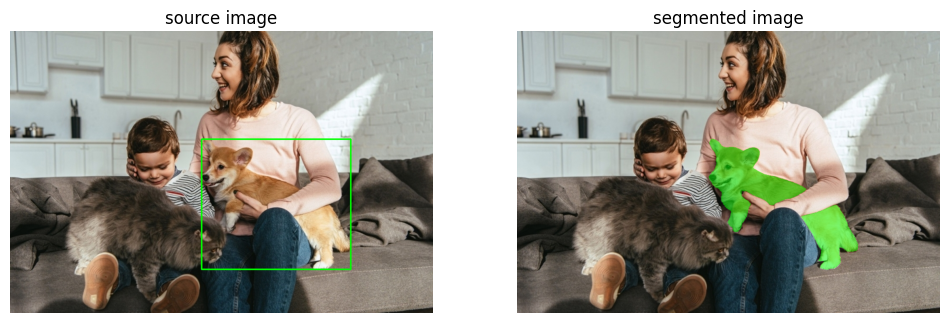

In [84]:
box_annotator = sv.BoundingBoxAnnotator()
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

# extract bounding box coordinates from detections
bounding_boxes = detections.xyxy

# annotate the source image with bounding boxes
source_image = image_bgr.copy()
for box in bounding_boxes:
    x_min, y_min, x_max, y_max = box
    cv2.rectangle(source_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# apply the masks to the image
segmented_image = image_bgr.copy()
for mask in masks:
    segmented_image[mask > 0] = [0, 255, 0]  # Set segmented areas to red

copy = image_bgr.copy()
# blend the annotated image with the original image using a low opacity
final_image = cv2.addWeighted(copy, 0.5, segmented_image, 0.5, 0)
sv.plot_images_grid(
    images=[source_image, final_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

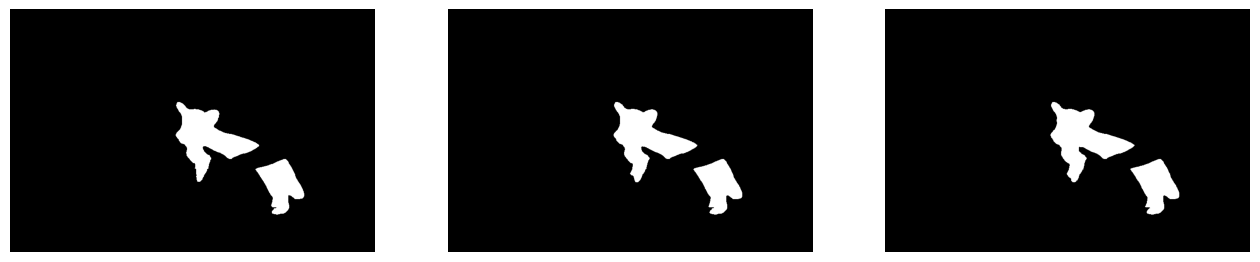

In [69]:
sv.plot_images_grid(
    images=masks,
    grid_size=(1, 3),
    size=(16, 4)
)